# Проект: Анализ убытков приложения Procrastinate Pro+

**Описание проекта**  
Компания-собственник приложения Procrastinate Pro+ несмотря на огромные вложения в рекламу в течение последних месяцев терпит убытки.  


**Цель данного исследования** - разобраться в причинах убытков и подготовить рекомендации по повышению эффективности рекламы. 


**Описание данных**  
В качестве исходной информации предоставлены три датасета с информацией о пользователях, привлеченных с 1 мая по 27 октября 2019 года:  
- лог сервера с данными об их посещениях (*visits_info_short.csv*);  
- выгрузка их покупок за этот период (*orders_info_short.csv*);  
- рекламные расходы (*costs_info_short.csv*).  

Структура *visits_info_short.csv*:  
- User Id — уникальный идентификатор пользователя,  
- Region — страна пользователя,  
- Device — тип устройства пользователя,  
- Channel — идентификатор источника перехода,  
- Session Start — дата и время начала сессии,  
- Session End — дата и время окончания сессии. 

Структура *orders_info_short.csv*:  
- User Id — уникальный идентификатор пользователя,  
- Event Dt — дата и время покупки,  
- Revenue — сумма заказа.  

Структура *costs_info_short.csv*:  
- dt — дата проведения рекламной кампании,  
- Channel — идентификатор рекламного источника,  
- costs — расходы на эту кампанию.  

**План исследования**  
1) Загрузка и изучение предоставленных данных;  
2) Предобработка данных;  
3) Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии;  
4) Исследовательский анализ данных;  
5) Маркетинговое исследование;  
6) Оценка окупаемости рекламы;  
7) Выводы.

In [18]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Загрузка и изучение информации о данных

В рамках данного раздела загрузим файлы и получим основную информацию о них.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

In [19]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

display('Информация о датасете visits')
visits.info()
display('Информация о датасете orders')
orders.info()
display('Информация о датасете costs')
costs.info()

'Информация о датасете visits'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


'Информация о датасете orders'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


'Информация о датасете costs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Согласно полученной информации пропуски в датасетах отсутствуют. Необходимо привести наименования столбцов к "змеиному" регистру, то есть к написанию строчными буквами, а пробелы заменить на нижнее подчеркивание. Также заменим тип данных в столбцах с датой и временем (Session Stars, Session End, Event Dt, dt). Дополнительно проверим данные на наличие дубликатов.

## Предобработка данных

### Изменение названий столбцов

In [20]:
# приведем названия столбцов к змеиному регистру
visits = visits.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel', 'Session Start':'session_start',
'Session End':'session_end'})
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})
costs = costs.rename(columns={'Channel':'channel'})

### Изменение типов данных

In [21]:
# Изменим тип данных в столбцах session_start и session_end датасета visits на datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# Изменим тип данных в столбце event_dt датасета orders на datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

# Изменим тип данных в стодбце dt датасета costs на date
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Проверка дубликатов

In [22]:
# Определим количество явных дубликатов в датасете visits
display(f'Количество дубликатов в visits составляет {visits.duplicated().sum()}')

# Определим количество явных дубликатов в датасете orders
display(f'Количество дубликатов в orders составляет {orders.duplicated().sum()}')

# Определим количество явных дубликатов в датасете costs
display(f'Количество дубликатов в costs составляет {costs.duplicated().sum()}')


'Количество дубликатов в visits составляет 0'

'Количество дубликатов в orders составляет 0'

'Количество дубликатов в costs составляет 0'

Явные дубликаты отсутствуют.

Для проверки неявных дубликатов убедимся, что названия каналов и устройств не дублируют друг друга.

In [23]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [24]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [25]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявные дубликаты в названиях каналов и устройств отсутствуют.  

**Вывод по разделу:** в рамках данного раздела мы провели предобработку данных: привели названия столбцов к единому виду, изменили типы данных в местах, где это было необходимо, а также провели проверку на наличие дубликатов.

## Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии

В рамках данного раздела определим функции, которые будем использовать для дальнейшего анализа.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [36]:
# Определение функции для создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].to_numpy().astype("datetime64[M]")

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [37]:
# для подсчёта Retention Rate
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [38]:
# Определение функции для подсчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [39]:
# Определение функции для подсчёта LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [40]:
# Определение функции для сглаживания данных
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [41]:
# Определение функции для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [42]:
# Определение функции для для построения графика конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [43]:
# Определение функции для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()  

**Вывод по разделу:** в рамках данного раздела мы определили функции для расчёта и анализа LTV, ROI, удержания и конверсии.

## Исследовательский анализ данных

В рамках данного раздела проведем следующие работы:
- составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

### Получение профилей пользователей  
Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу.

In [45]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Установим момент и горизонт анализа данных. Данные предоставлены о пользователях за период с 1 мая по 27 октября 2019 года. На календаре 1 ноября 2019 года, а горизонт анализа составляет 14 дней.

Определим минимальную и максимальную даты привлечения пользователей.

In [46]:
date_min = profiles['dt'].min()
date_min

datetime.date(2019, 5, 1)

In [47]:
# date_max = observation_date - timedelta(days=horizon_days - 1)
date_max = profiles['dt'].max()
date_max

datetime.date(2019, 10, 27)

**Вывод по подразделу:** в данном подразделе мы составили профили пользователей, в которых отражены дата первого подключения пользователя, источник подключения, вид устройства, страна, дата и месяц подключения, вхождение в состав платящих пользователей, а также стоимость привлечения.  
Также мы определили, что минимальной датой привлечения пользователей является 1 мая 2019 года, а максимальной ~~с учетом горизонта анализа - 19~~ 27 октября 2019 года. Информация о данных предоставлена верно.

### Анализ по странам

В рамках данного подраздела определим, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [48]:
region_profiles = profiles.groupby('region').agg({'user_id':'nunique', 'payer':['sum', 'mean']}).reset_index()
region_profiles.columns = ['region', 'user_count', 'payer_count', 'payer_share']
region_profiles.sort_values(by = 'payer_share', ascending=False)

,region,user_count,payer_count,payer_share
3,United States,100002,6902,0.069019
1,Germany,14981,616,0.041119
2,UK,17575,700,0.039829
0,France,17450,663,0.037994


**Вывод по подразделу:** в таблице выше видно, что пользователи приходят в приложение из США, Германии, Великобритании и Франции. Наибольшая доля покупателей приходится на США (более 6%). Эта же страна является лидером по посещениям приложения. 

### Анализ по устройствам

В рамках данного подраздела выявим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [49]:
device_profiles = profiles.groupby('device').agg({'user_id':'nunique', 'payer':['sum', 'mean']}).reset_index()
device_profiles.columns = ['device', 'user_count', 'payer_count', 'payer_share']
device_profiles.sort_values(by = 'payer_share', ascending=False)

,device,user_count,payer_count,payer_share
1,Mac,30042,1912,0.063644
3,iPhone,54479,3382,0.062079
0,Android,35032,2050,0.058518
2,PC,30455,1537,0.050468


**Вывод по подразделу:** в таблице выше видно, что пользователи приложения пользуются устройствами Mac, iPhone, Android, PC. Наибольшая доля платящих пользователей среди использующих Mac. На втором месте владельцы iPhone.

### Анализ по источникам привлечения

В рамках данного подраздела изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [50]:
channel_profiles = profiles.groupby('channel').agg({'user_id':'nunique', 'payer':['sum', 'mean']}).reset_index()
channel_profiles.columns = ['channel', 'user_count', 'payer_count', 'payer_share']
channel_profiles.sort_values(by = 'payer_share', ascending=False)

,channel,user_count,payer_count,payer_share
1,FaceBoom,29144,3557,0.122049
0,AdNonSense,3880,440,0.113402
9,lambdaMediaAds,2149,225,0.104700
6,TipTop,19561,1878,0.096007
5,RocketSuperAds,4448,352,0.079137
7,WahooNetBanner,8553,453,0.052964
8,YRabbit,4312,165,0.038265
3,MediaTornado,4364,156,0.035747
2,LeapBob,8553,262,0.030633
4,OppleCreativeMedia,8605,233,0.027077


**Вывод по подразделу:** по результатам расчетов видно, что пользователи приходят в приложение через следующие каналы: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds, WahooNetBanner, YRabbit, MediaTornado, LeapBob, OppleCreativeMedia. Почти половина пользователей попадают в приложение самостоятельно, однако доля платящих пользователей среди "органических" пользователей минимальна. Больше всего платящих пользователей среди пришедших через FaceBoom (более 12%).

**Вывод по разделу.**  
В рамках данного раздела были составлены профили пользователей и определены минимальная дата привлечения пользователей (1 мая 2019 г.) и максимальная с учетом горизонта анализа (19 октября 2019 г.).  
Максимальное количество платящих пользователей приходится на США.  
Согласно анализу платящие пользователи предпоитают Mac - на это устройство приходится максимальная доля покупателей.  
Наибольшее число платящих пользователей пришло через канал FaceBoom.

## Маркетинг

В рамках данного раздела:
- посчитаем общую сумму расходов на маркетинг.
- выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.
- узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.


### Общие расходы на маркетинг

In [52]:
# Определим общую сумму затрат на маркетинг
total_cost = round(costs['costs'].sum(), 2)
display(f'Общие затраты на маркетинг составили {total_cost} у.е.')

'Общие затраты на маркетинг составили 105497.3 у.е.'

### Затраты на маркетинг по источникам

In [53]:
# Определим общую сумму затрат на маркетинг по источникам
channel_cost = costs.groupby('channel')['costs'].agg('sum').reset_index()
channel_cost['share'] = channel_cost['costs']/total_cost # определим долю затрат на канал в общих затратах
channel_cost.sort_values(by='share', ascending=False)

,channel,costs,share
6,TipTop,54751.30,0.518983
1,FaceBoom,32445.60,0.307549
7,WahooNetBanner,5151.00,0.048826
0,AdNonSense,3911.25,0.037074
4,OppleCreativeMedia,2151.25,0.020392
5,RocketSuperAds,1833.00,0.017375
2,LeapBob,1797.60,0.017039
9,lambdaMediaAds,1557.60,0.014764
3,MediaTornado,954.48,0.009047
8,YRabbit,944.22,0.008950


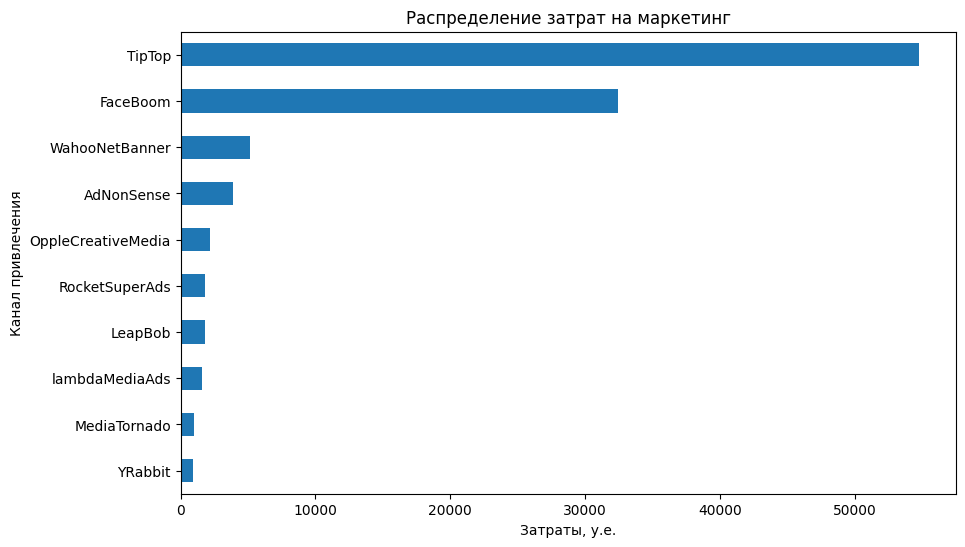

In [54]:
#costs.groupby('channel')['costs'].agg('sum').plot(kind='pie', title='Распределение затрат на маркетинг', autopct='%.2f%%', figsize = (10,10));
costs.groupby('channel')['costs'].agg('sum').sort_values().plot(kind='barh', title='Распределение затрат на маркетинг', figsize = (10,6));
plt.xlabel('Затраты, у.е.');
plt.ylabel('Канал привлечения');

Из таблицы и графика выше следует, что наибольшая доля маркетинговых расходов приходится на канал TipTop (54751.30 у.е.). На втором месте FaceBoom (32445.60 у.е.).

### Динамика изменения расходов во времени по источникам  

Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику. Для начала добавим в таблицу costs дополнительные столбцы с номером недели и месяца.

In [55]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

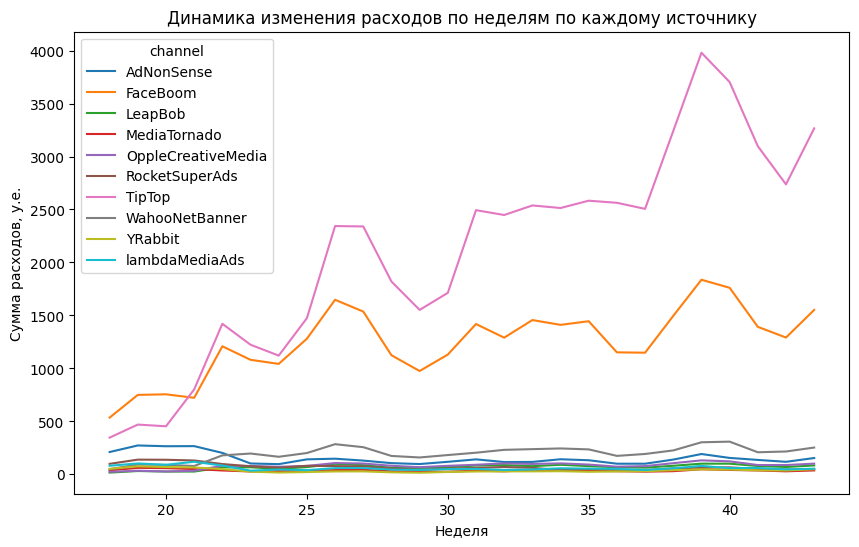

In [56]:
# Построение графика с визуализацией динамики изменения расходов по неделям
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(title='Динамика изменения расходов по неделям по каждому источнику', figsize=(10,6));
plt.xlabel('Неделя');
plt.ylabel('Сумма расходов, у.е.');

На графике наблюдается существеный рост расходов на маркетинг по каналам TipTop и FaceBoom. По остальным каналам затраты стабильно низкие.

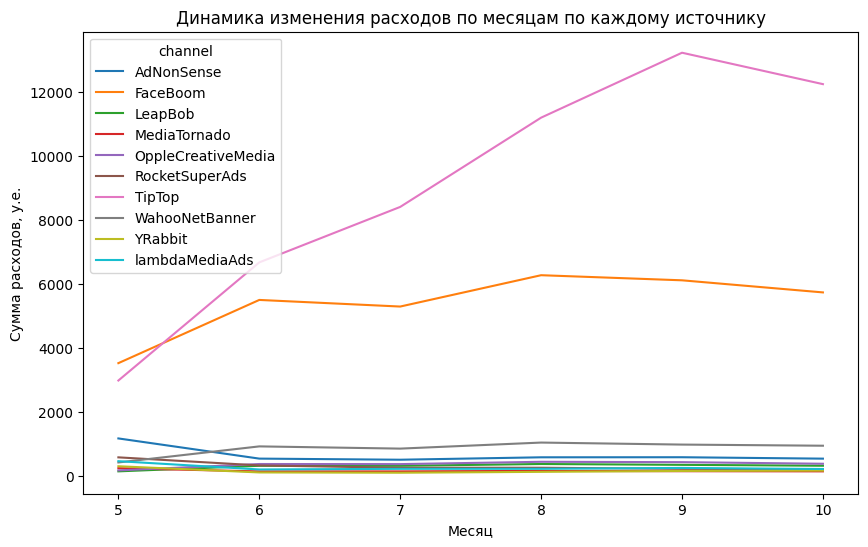

In [57]:
# Построение графика с визуализацией динамики изменения расходов по месяцам
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(title='Динамика изменения расходов по месяцам по каждому источнику', figsize=(10,6));
plt.xlabel('Месяц');
plt.ylabel('Сумма расходов, у.е.');

На графике также наблюдается существеный рост расходов на маркетинг по каналам TipTop и FaceBoom. По остальным каналам затраты стабильно низкие.

### Средняя стоимость привлечения пользователя по источникам

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


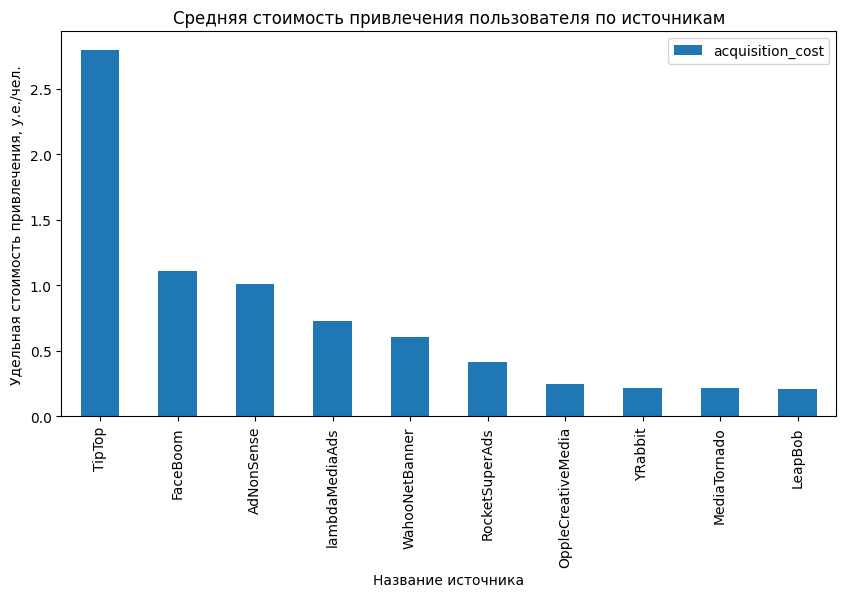

In [58]:
# Составим сводную таблицу со средней стоимостью привлечения пользователя по источникам, 
# исключив органических пользователей, так как их стоимость привлеченя равна нулю
mean_acq_cost = profiles.query('channel != "organic"').pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending=False)
display(mean_acq_cost)
mean_acq_cost.plot(kind='bar', title='Средняя стоимость привлечения пользователя по источникам', figsize=(10,5));
plt.xlabel('Название источника');
plt.ylabel('Удельная стоимость привлечения, у.е./чел.');

По результатам расчетов видно, что максимальная удельная стоимость привлечения пользователей у источника TipTop - 2,80 у.е./чел. Минимальное значение у LeapBob - 0.21 у.е./чел.

**Выводы по разделу.**  

В рамках данного раздела было проведено исследование о стоимости маркетинговых кампаний приложения Procrastination Pro+.  
Общие затраты на маркетинг составили 105497.3 у.е. Наибольшая доля маркетинговых расходов приходится на канал TipTop (54751.30 у.е.). На втором месте FaceBoom (32445.60 у.е.).  
Оценив динамику расходов на маркетинг по неделям и месяцам мы выявили, что рост расходов на эти источники существенно вырос с мая по октябрь. Затраты по другим источникам изменялись незначительно.  
Максимальная удельная стоимость привлечения пользователей у источника TipTop - 2,80 у.е./чел. Минимальное значение у LeapBob - 0.21 у.е./чел.


## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Исключим из анализа органических пользователей, так как они привлечены по естественным каналам, а не через рекламу, соответственно, собственник приложения не нес затрат на их привлечение.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на слеующие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишем вывод, опишем возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [59]:
# Исключим органических пользователей
profiles = profiles.query('channel != "organic"')

Установим момент и горизонт анализа данных. Данные предоставлены о пользователях за период с 1 мая по 27 октября 2019 года. На календаре 1 ноября 2019 года, а горизонт анализа составляет 14 дней.

In [60]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Анализ окупаемости рекламы  

Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

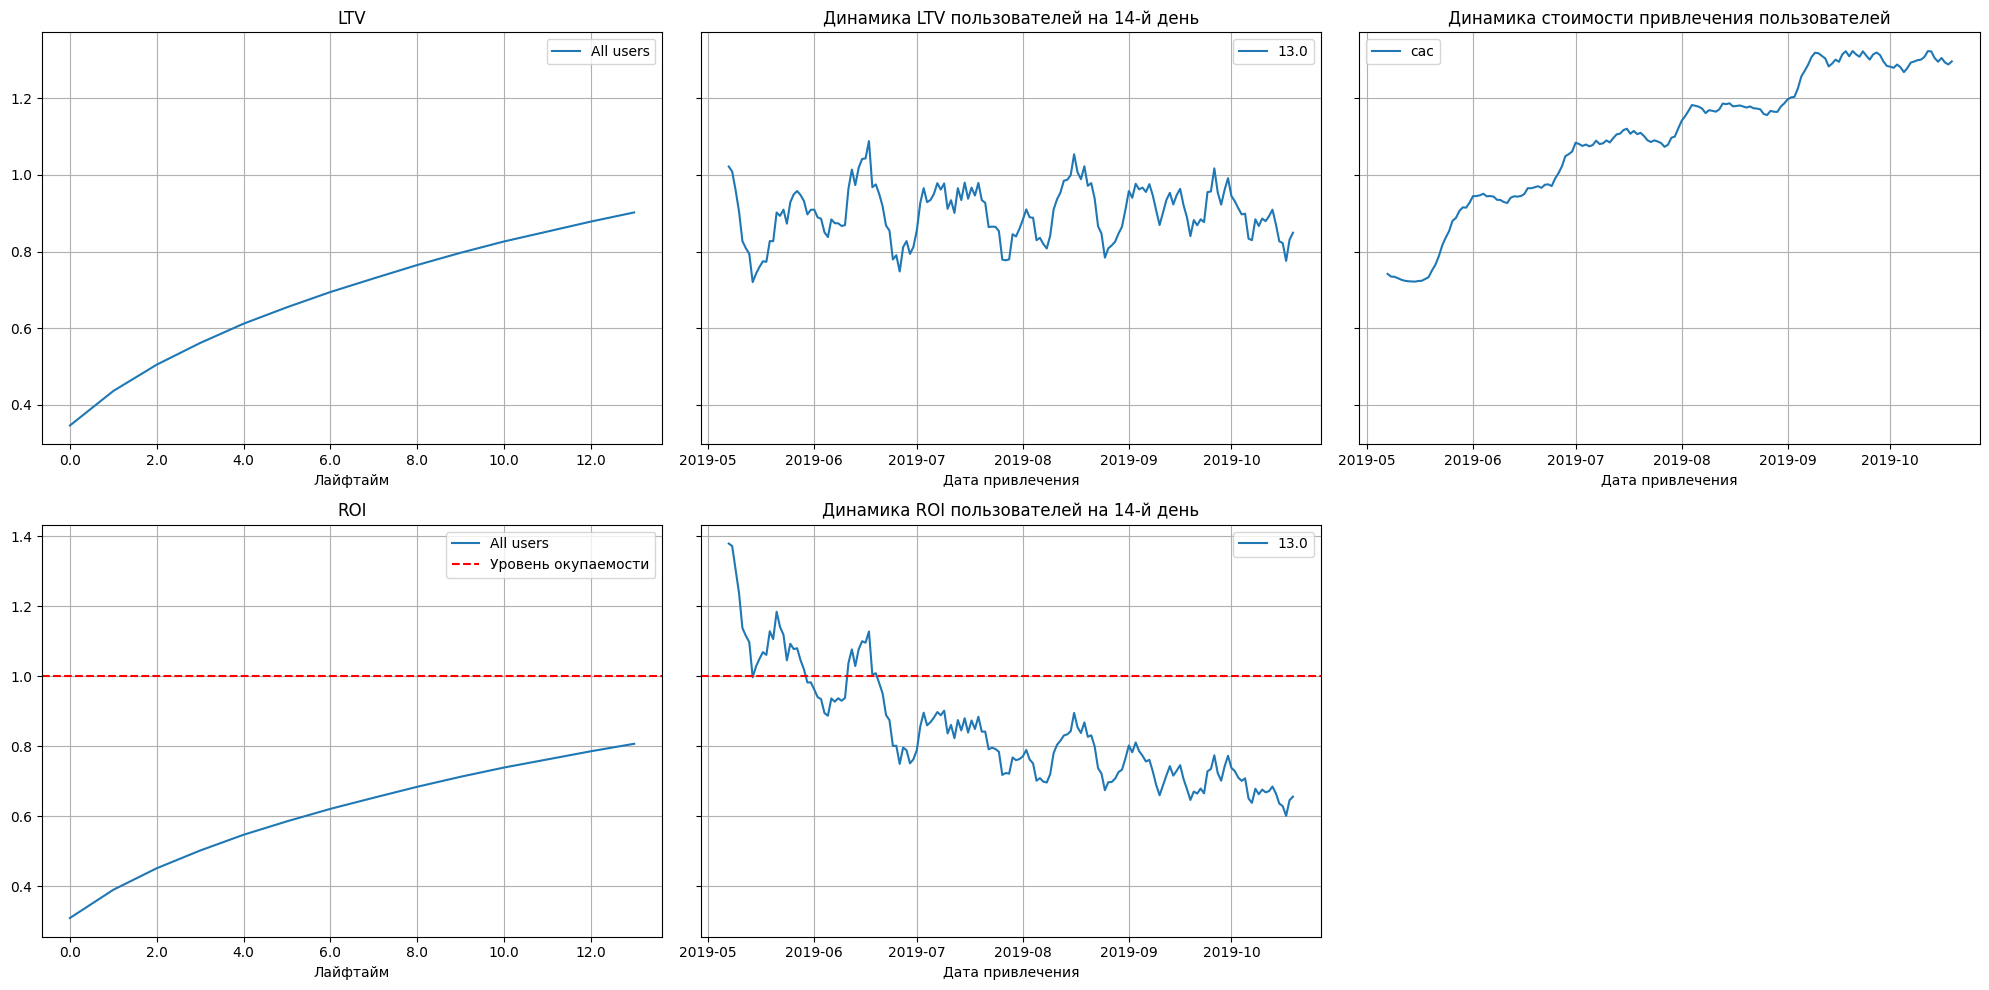

In [61]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:  
- реклама не окупается. Уровень ROI к 14 дню составляет чуть более 80%;  
- наблюдается снижение окупаемости в течение года: до июня ROI превышает уровень окупаемости, а после середины июня не достигает его и стабильно снижается;  
- наблюдается рост САС. На графиках видно, что темп снижения выручки сопоставим с темпом роста затрат на привлечение пользователей в течение анализируемого периода. Возможно, отсутствие окупаемости может быть связано с ростом затрат на рекламу;  
- LTV стабилен, как и его динамика. Значит, дело не в ухудшении качества пользователей.

### Анализ окупаемости рекламы с разбивкой по устройствам  

Рассчитаем и визуализируем LTV и ROI по устройствам, вызвав функции get_ltv() и plot_ltv_roi().

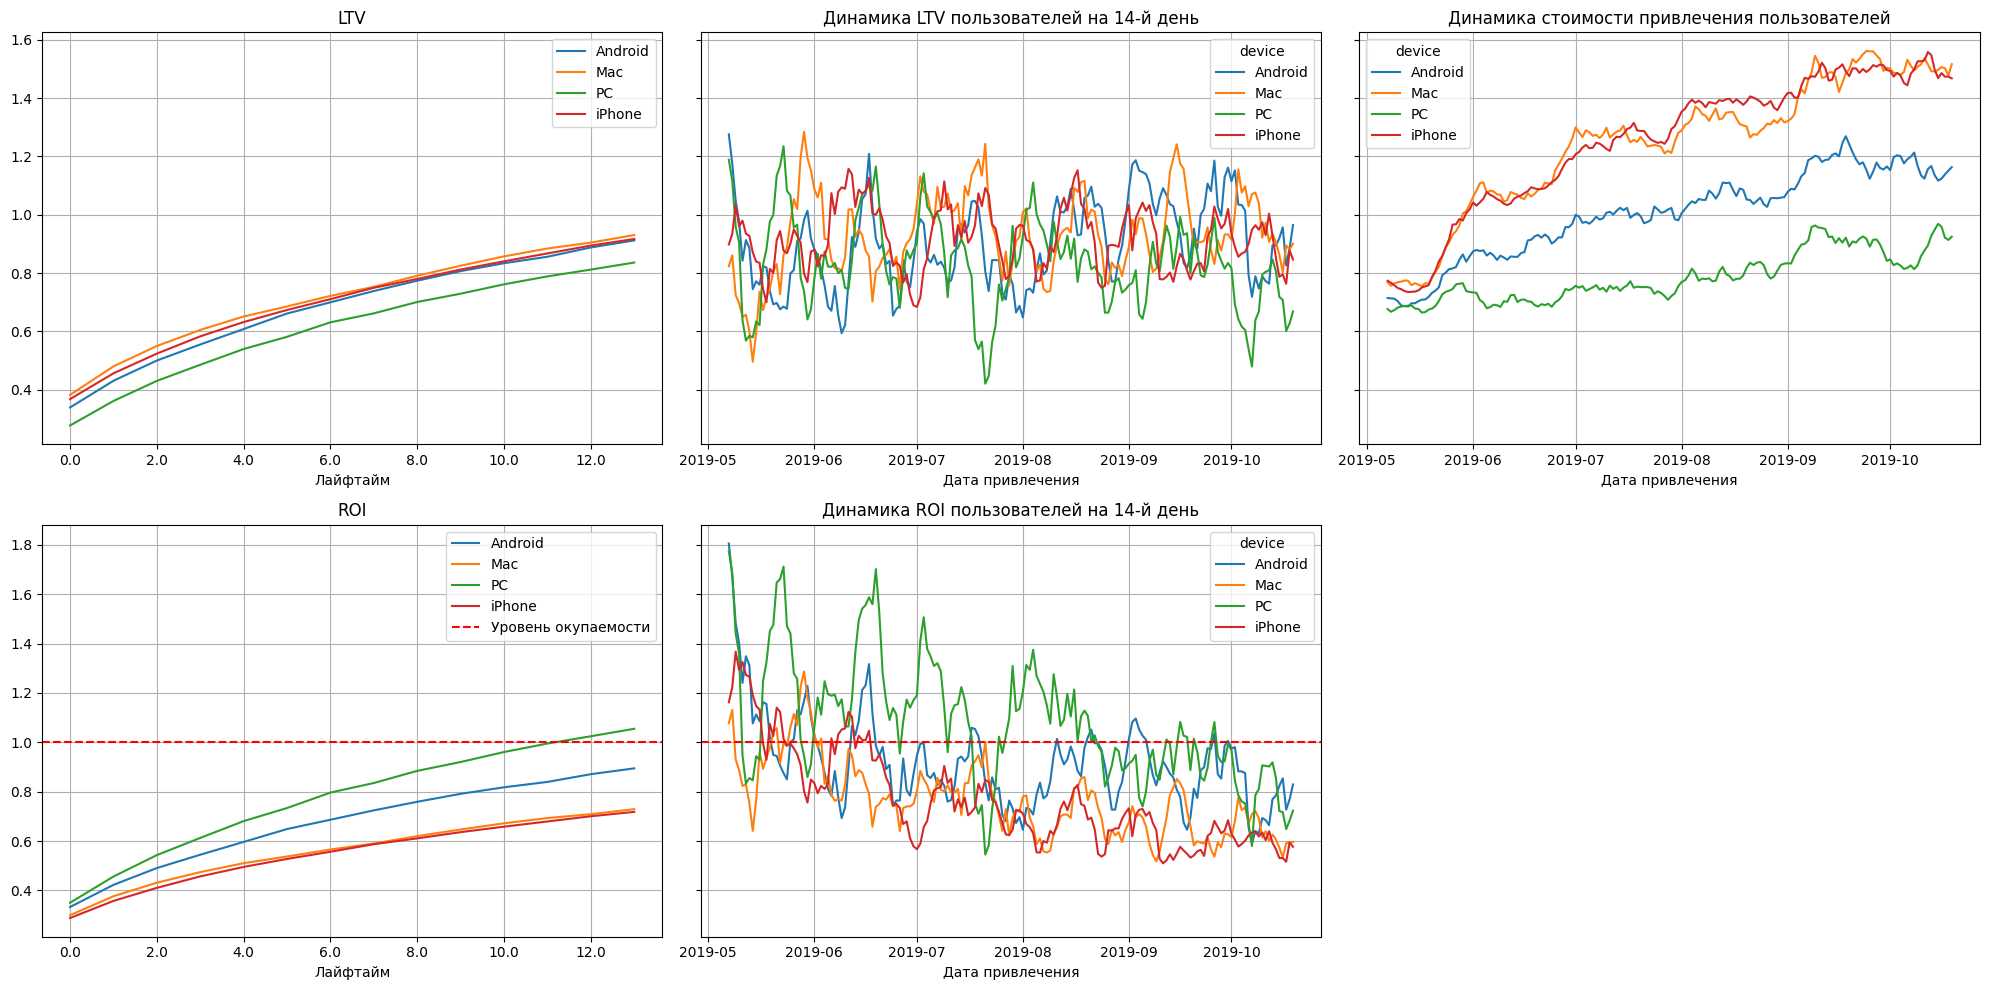

In [62]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'], ignore_horizon=False
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:  
- окупаемость рекламы слегка превышает уровень окупаемости только у пользователей PC. ROI пользователей Android на 14 день достигает 0.9, а окупаемость пользователей Mac и iPhone находится на уровне 0.7;  
- динамика ROI имеет тенденцию к снижению у всех категорий пользователей;  
- также наблюдается рост стоимости привлечения пользователей по всем типам устройств. Наибольший рост стоимости наблюдается у пользователей Max и iPhone;  
- LTV стабилен для всех устройств.

### Анализ окупаемости рекламы по странам  

Рассчитаем и визуализируем LTV и ROI по устройствам, вызвав функции get_ltv() и plot_ltv_roi().

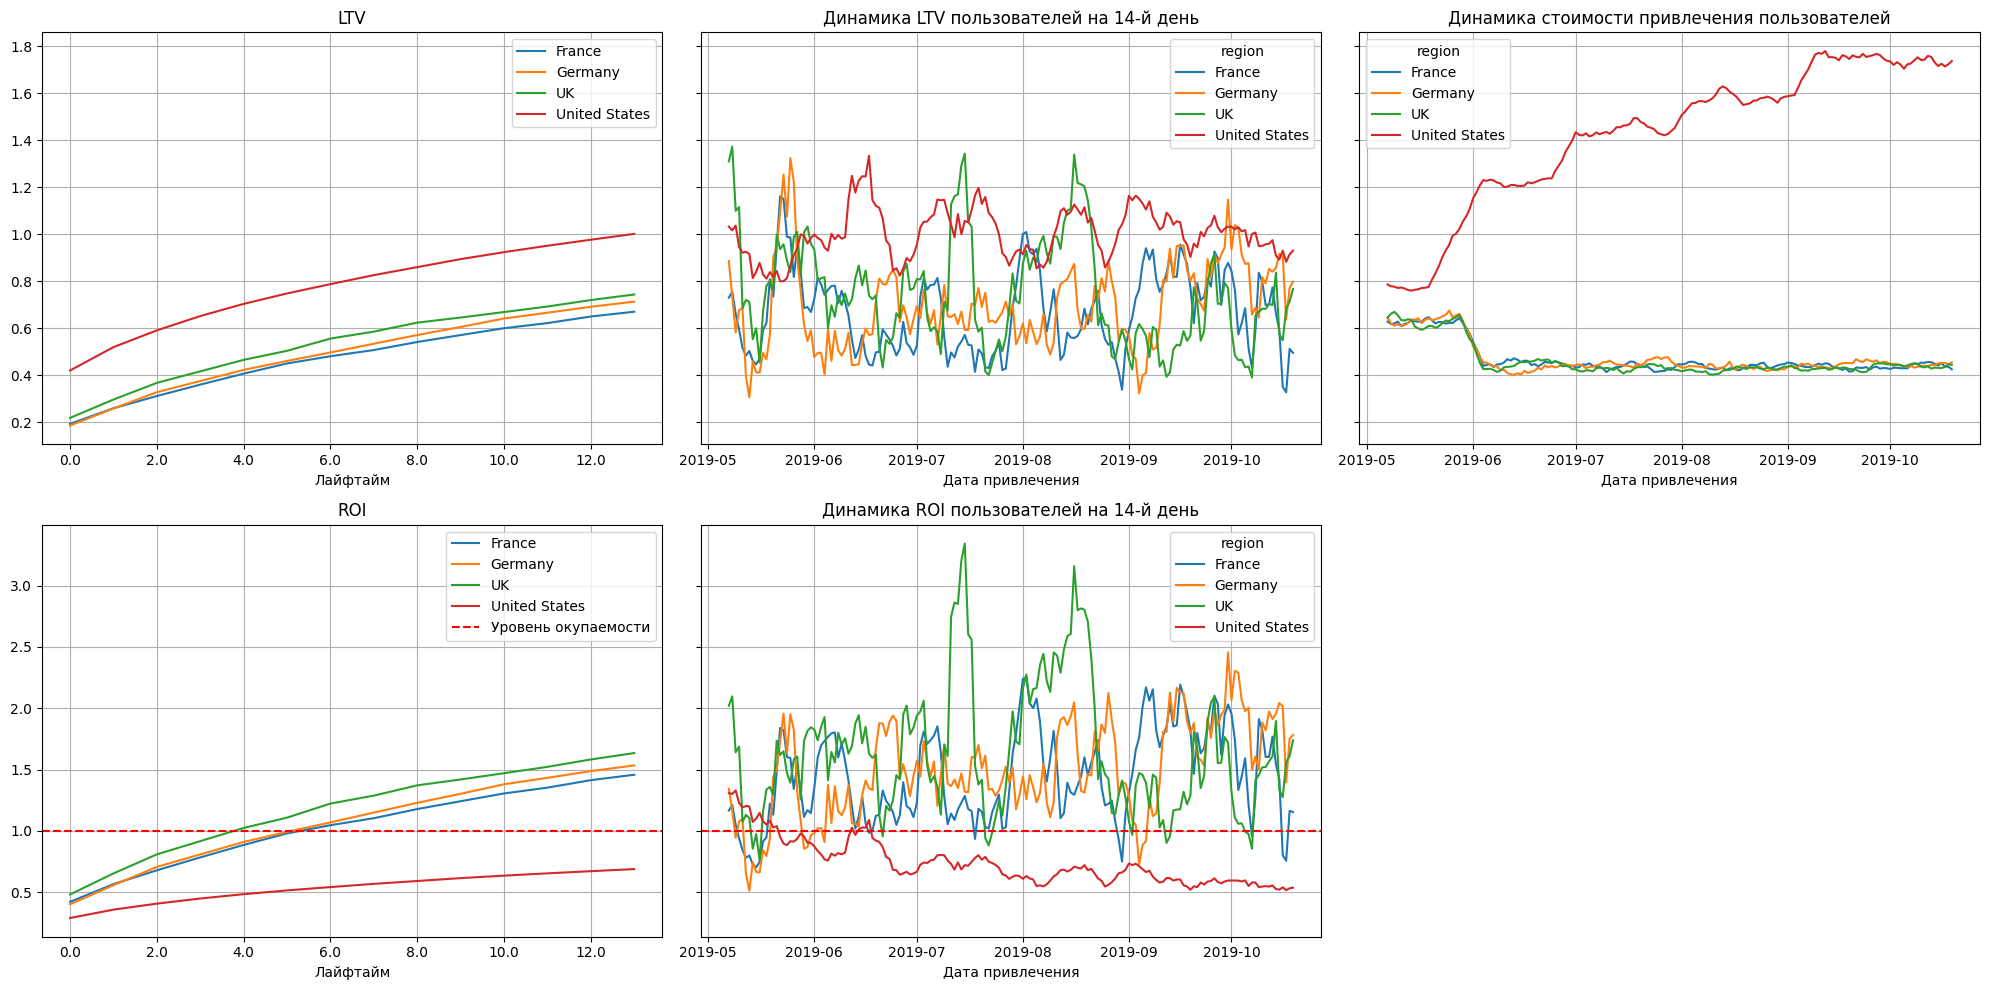

In [63]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'], ignore_horizon=False
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

На графиках выше видно, что:  
- LTV пользователей из США значительно превышает и выдалется на фоне остальных регионов. На графике динамики также видно, что LTV для США в среднем стабильно выше, за исключением нескольких аномально высоких значений для Великобритании и Германии;  
- в то же время окупаемость рекламы превышает уровень окупаемости для всех регионов, кроме США. Так, ROI для Франции и Германии находится в районе 1.5, для Великобритании - 1.6. Окупаемость пользователей из США не достигает уровня окупаемости и составляет около 0.7. Динамика окупаемости для США также стабильно ниже порога окупаемости и имеет енденцию к снижению в течение года, а отличие от остальных стран;  
- стоимость привлечения пользователей из США показывает стабильный и устойчивый рост в течение периода исследования, в отличие от стоимости привлечения покупателей из других стран.

### Анализ окупаемости рекламы по каналам привлечения  

Рассчитаем и визуализируем LTV и ROI по каналам, вызвав функции get_ltv() и plot_ltv_roi().

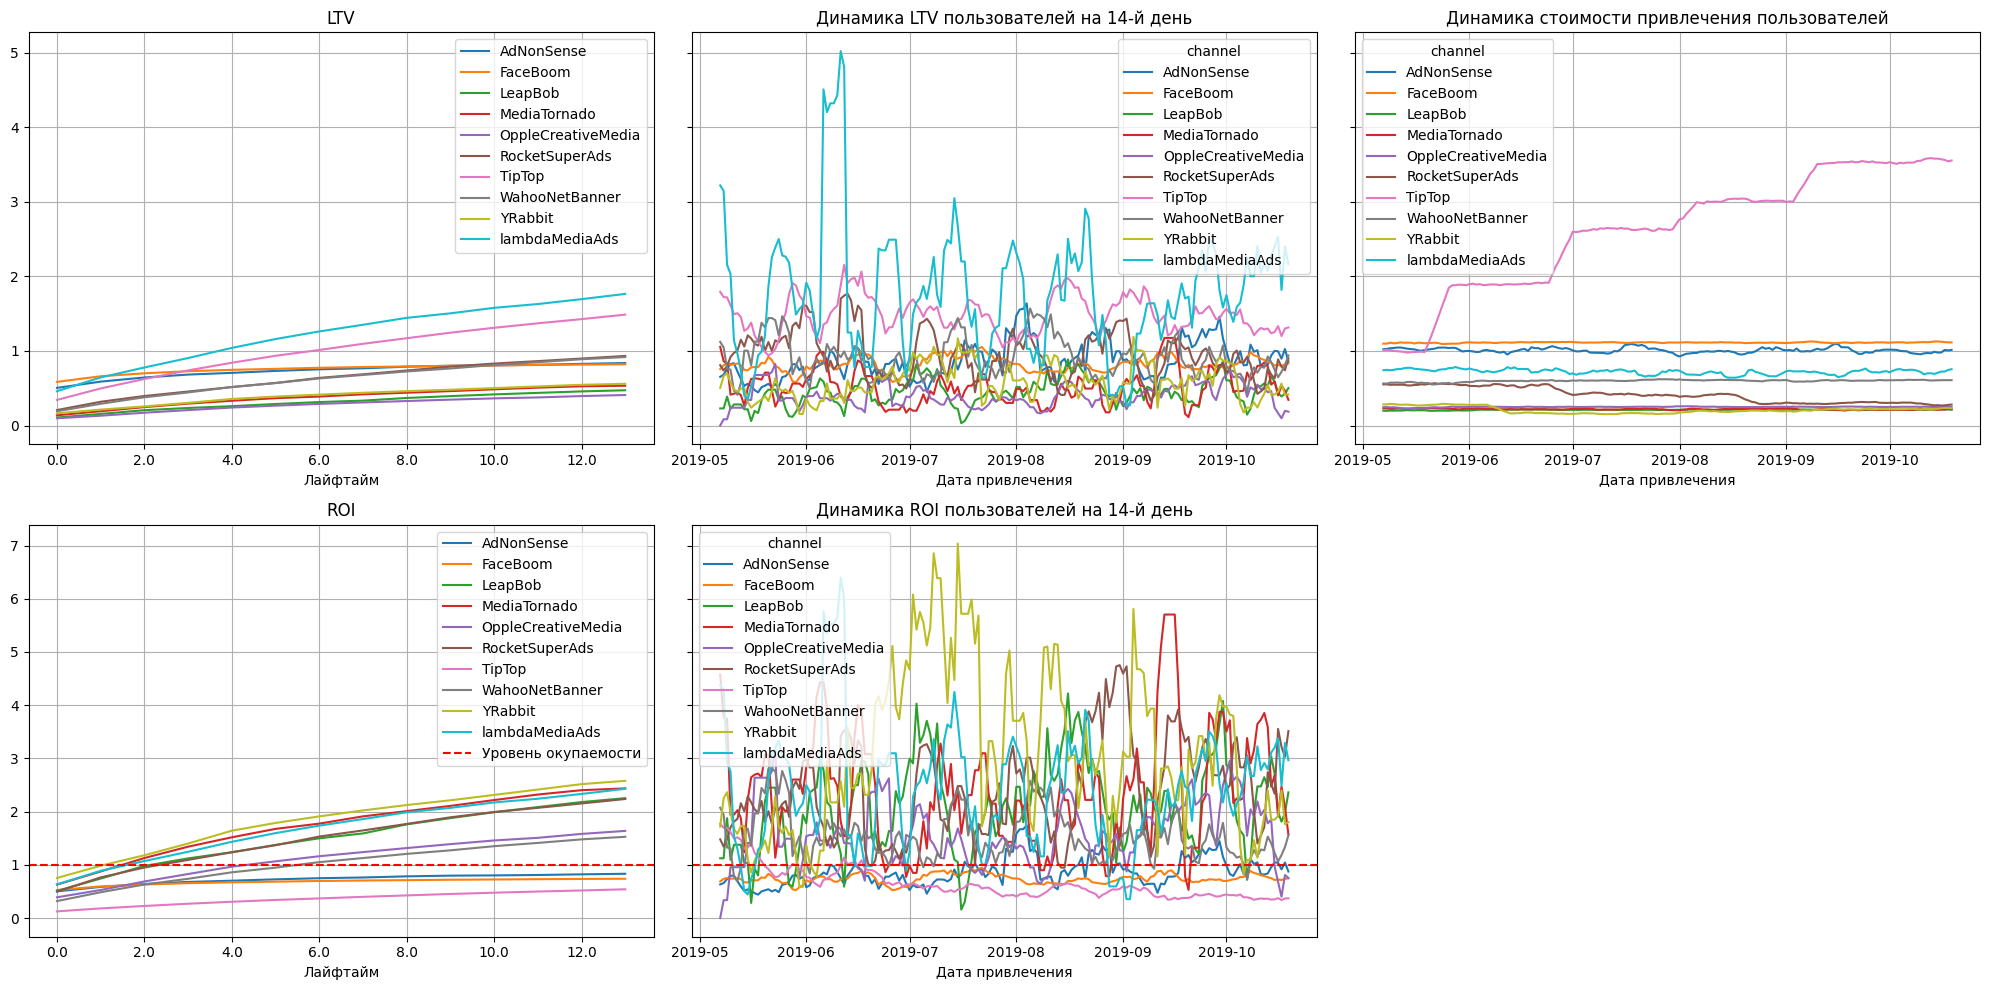

In [64]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из-за большого числа каналов привлечения и сильных скачков графика увеличим размер окна сглаживания с 7 дней до 14 для удобства чтения графиков.

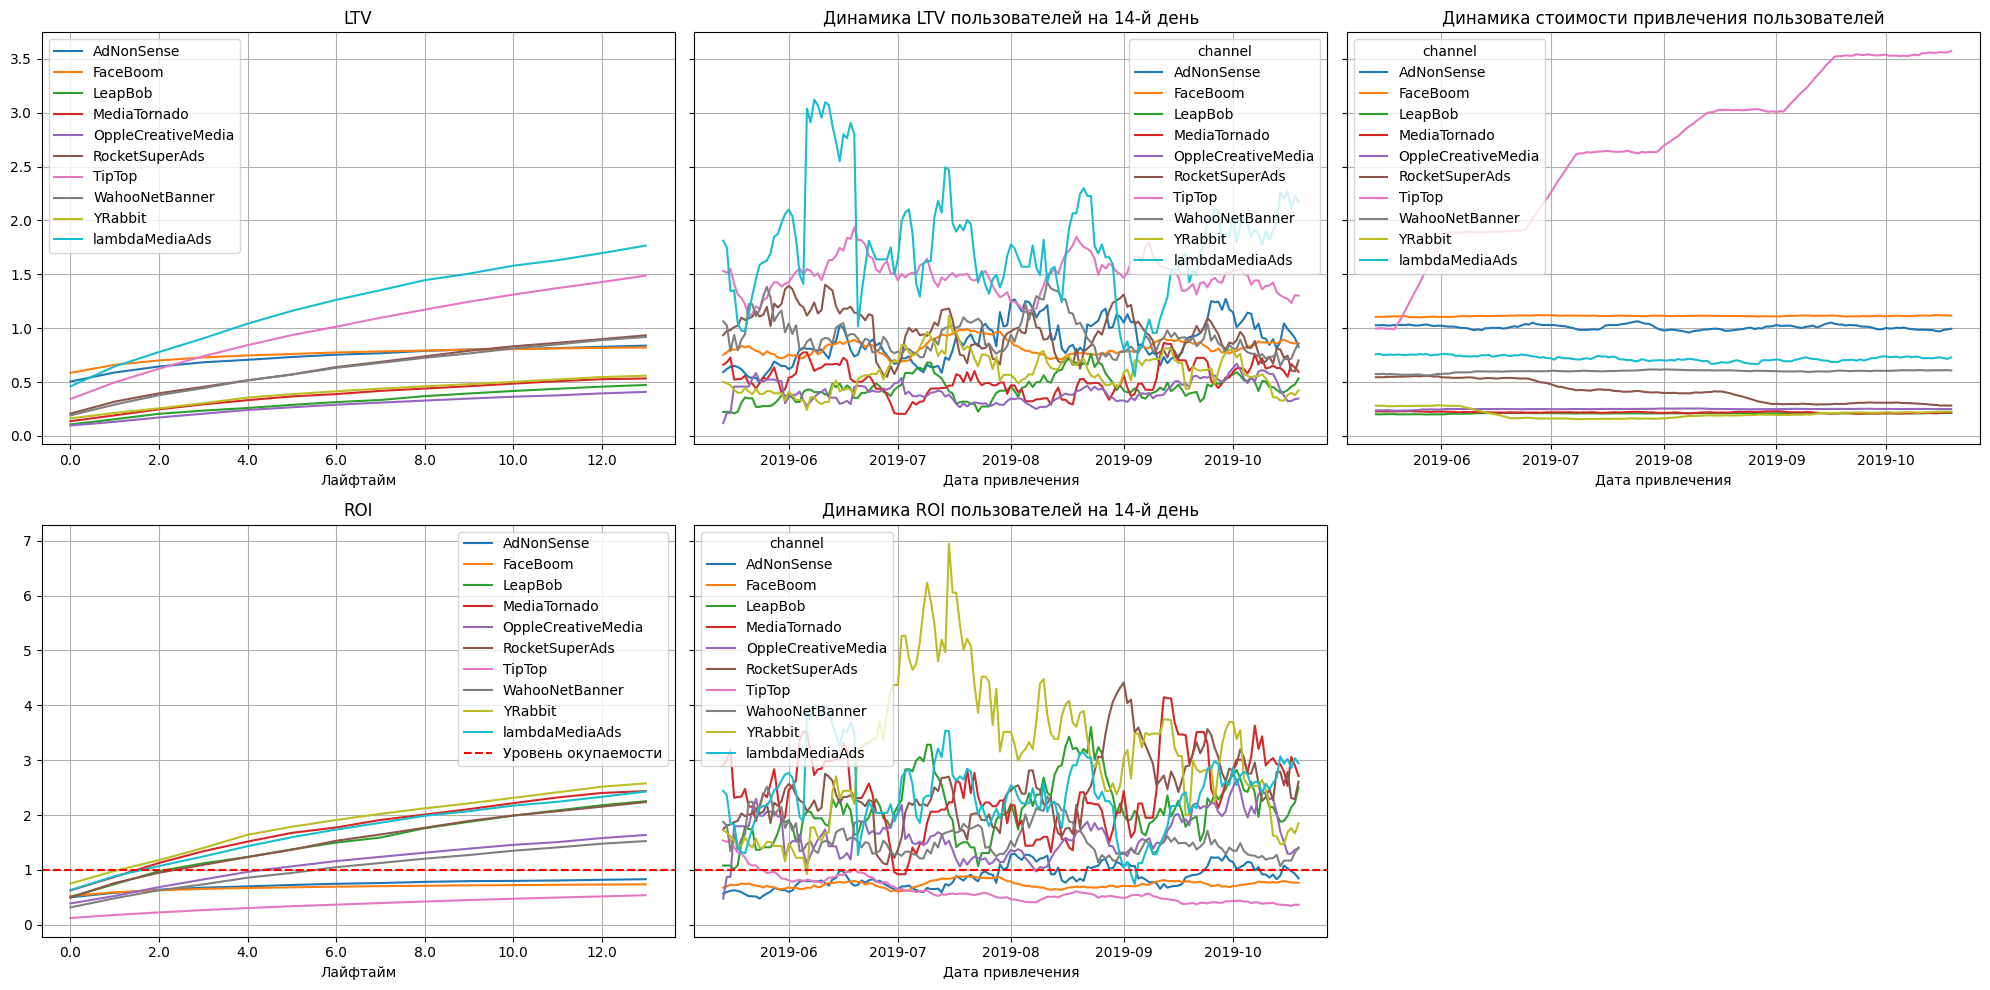

In [65]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

По полученным графикам можно сделать следущие выводы: 
- LTV пользователей, привлеченных через lambdaMediaAds и TipTop максимальны, это же видно и на графике динамики LTV;  
- стоимость привлечения пользователей через TipTop существенно выросла в течение анализируемого периода. Стоимость привлечения по другим каналам достаточно стабильна;  
- доходы с пользователей, привлекаемых по каналам AdNonSense, FaceBoom и TipTop не окупаются. Это видно и на графике динамики ROI: доходы по этим каналам не превышают уровень окупаемости стабильно в течение всего срока анализа. При этом окупаемость пользователей, привлеченных через TipTop минимальна.

Дополнительно рассмотрим окупаемость рекламы по каналам привлечения для пользователй из США, как для единственной страны, не преодолевшей порог окупаемости.

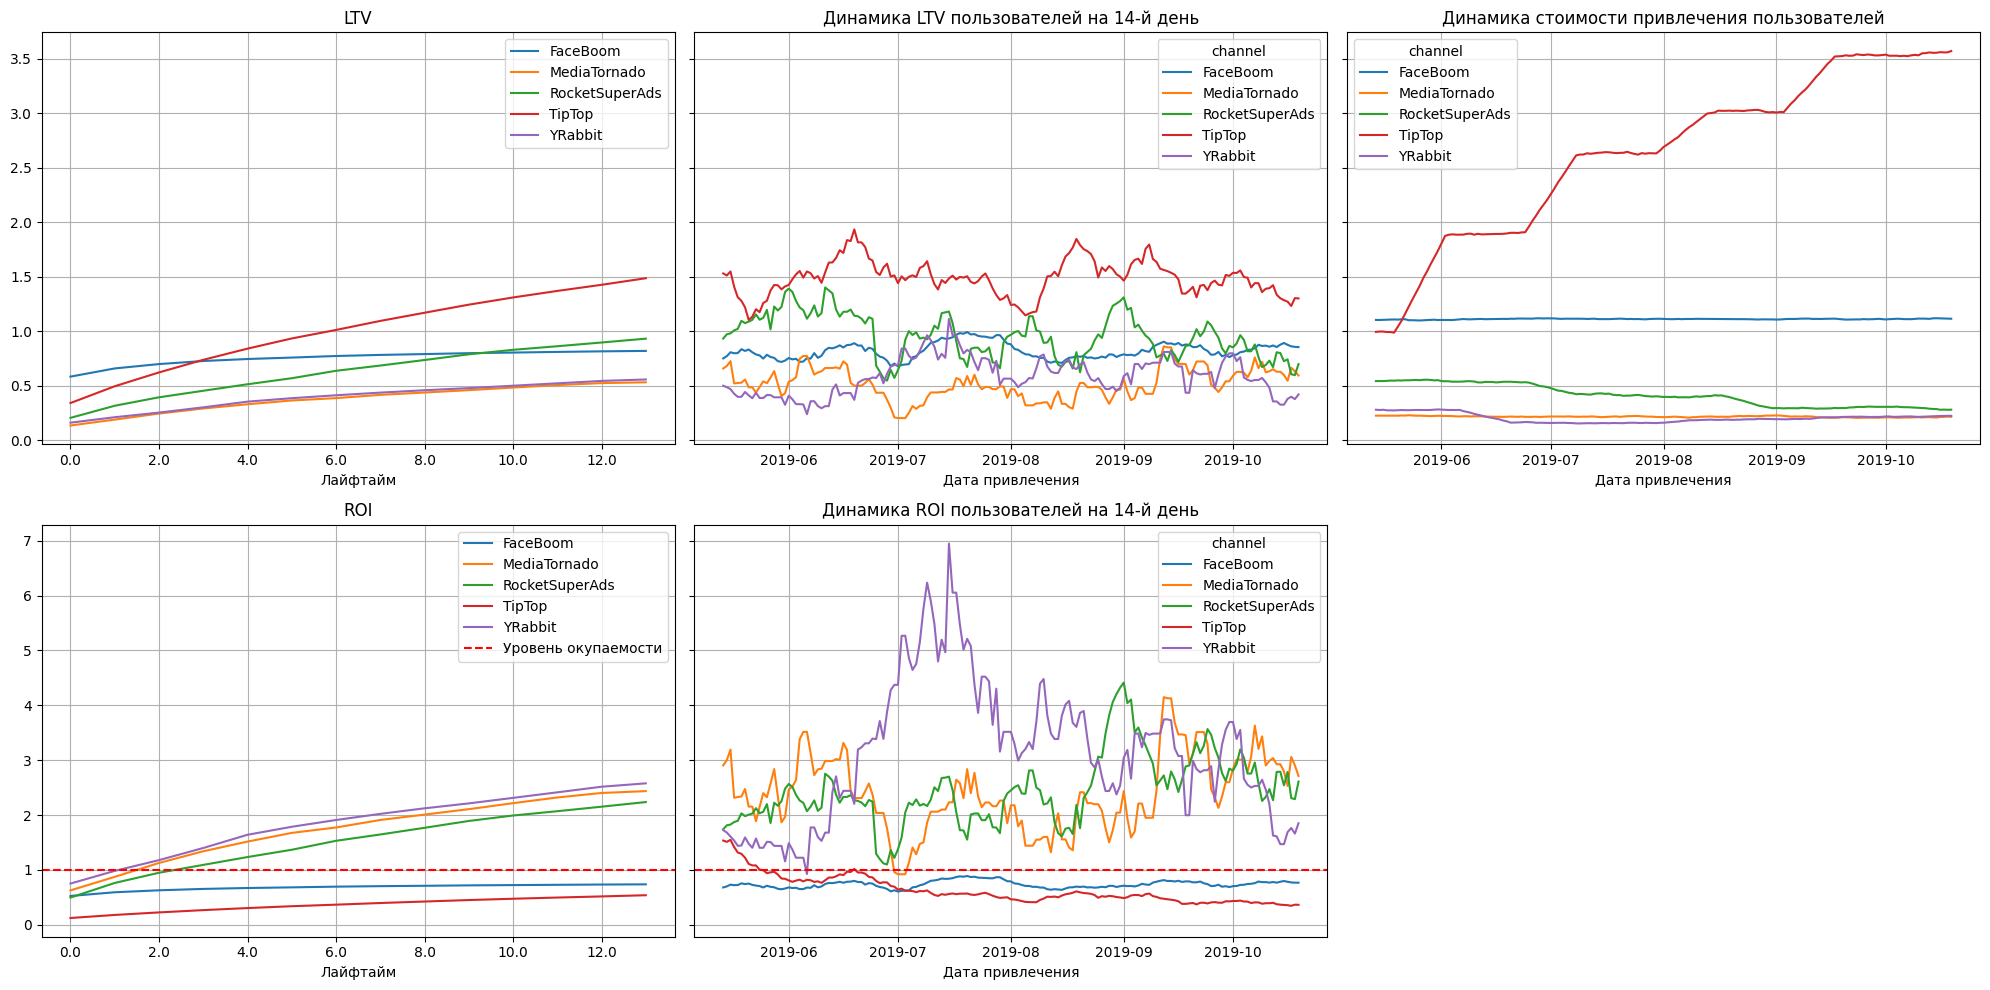

In [66]:
us_profiles = profiles.query('region == "United States"')
ltv_us_raw, ltv_us_grouped, ltv_us_history, roi_us_grouped, roi_us_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False
)
plot_ltv_roi(ltv_us_grouped, ltv_us_history, roi_us_grouped, roi_us_history, horizon_days, window=14)

На полученных графиках видно, что:  
- пользователи из США привлекались по каналам FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit;  
- пользователи, привлеченные через YRabbit, MediaTornado и RocketSuperAds достигают и существенно превышают уровень уровень окупаемости на протяжении всего периода анализа. ROI для пользователей, привлеченных через FaceBoom и TipTop не достигает уровня окупаемости;  
- наблюдается существенный рост стоимости привлечения через TipTop. Стоимость привлечения через YRabbit, MediaTornado и RocketSuperAds находится на стабильно низком уровне.  

Таким образом, на текущем этапе можно сделать промежуточный вывод о том, что пользователи из США, привлеченные через FaceBoom и TipTop стабильно не окупаются, при этом стоимость привлечения этих пользователей существенно превышает стоимость привлечения по другим каналам и из других регионов.  

Следующим этапом рассчитаем конверсию и удержание для пользователей из США по устройствам и каналам привлечения.

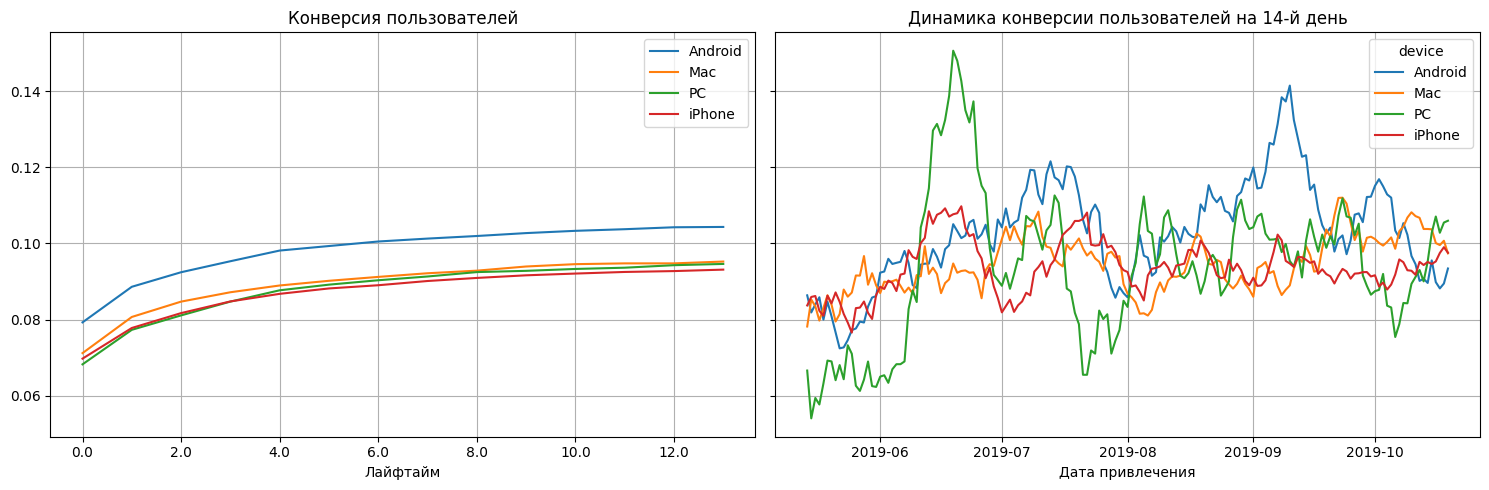

In [67]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    us_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Судя по графикам, наиболее хорошо конвертируются пользователи Android. Пользователи Mac, iPhone и PC находятся приблизительно на одном уровне. За весь анализируемый период наблюдается рост конверсии по всем категориям устройств.

### Анализ конверсии по каналам привлечения

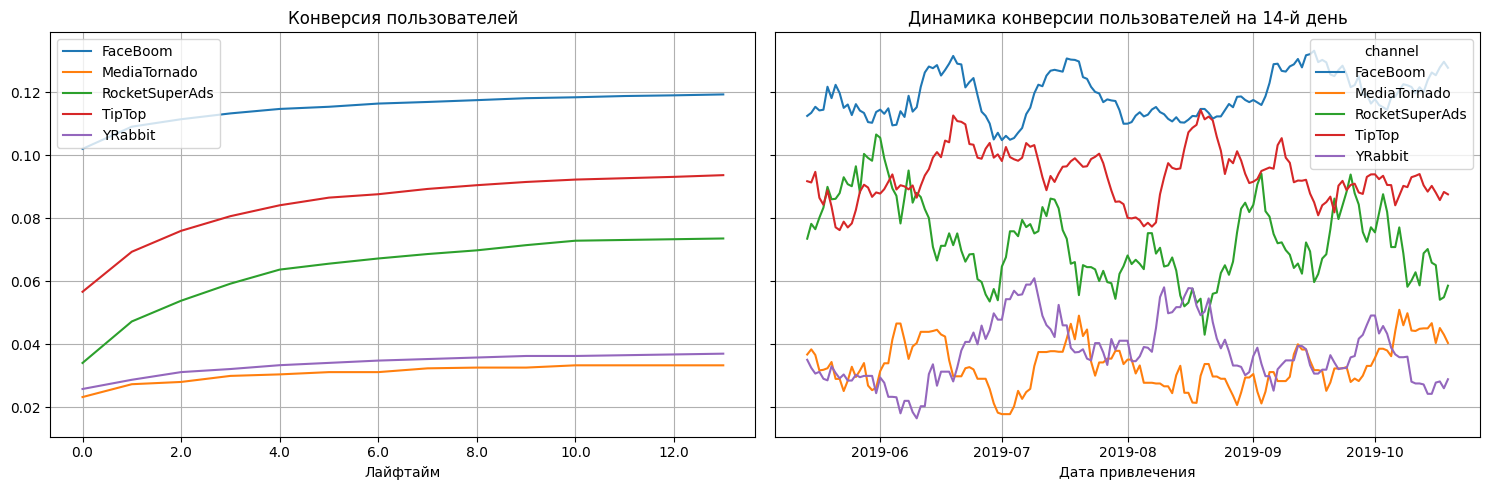

In [68]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    us_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

На графиках видно, что максимальная конверсия в среднем и в течение всего анализируемого периода у пользователей, привлеченных через FaceBoom. На втором месте TipTop. Минимальная конверсия у MediaTornado и YRabbit.  
Не смотря на некоторую сезонность, конверсия по всем каналам привлечения остается стабильной за весь анализируемй период.  

Таким образом, можно сделать промежуточный вывод о том, что проблема окупаемости не связана с конверсией. Следующим этапом проанализируем удержание пользователей.

### Анализ удержания по устройствам

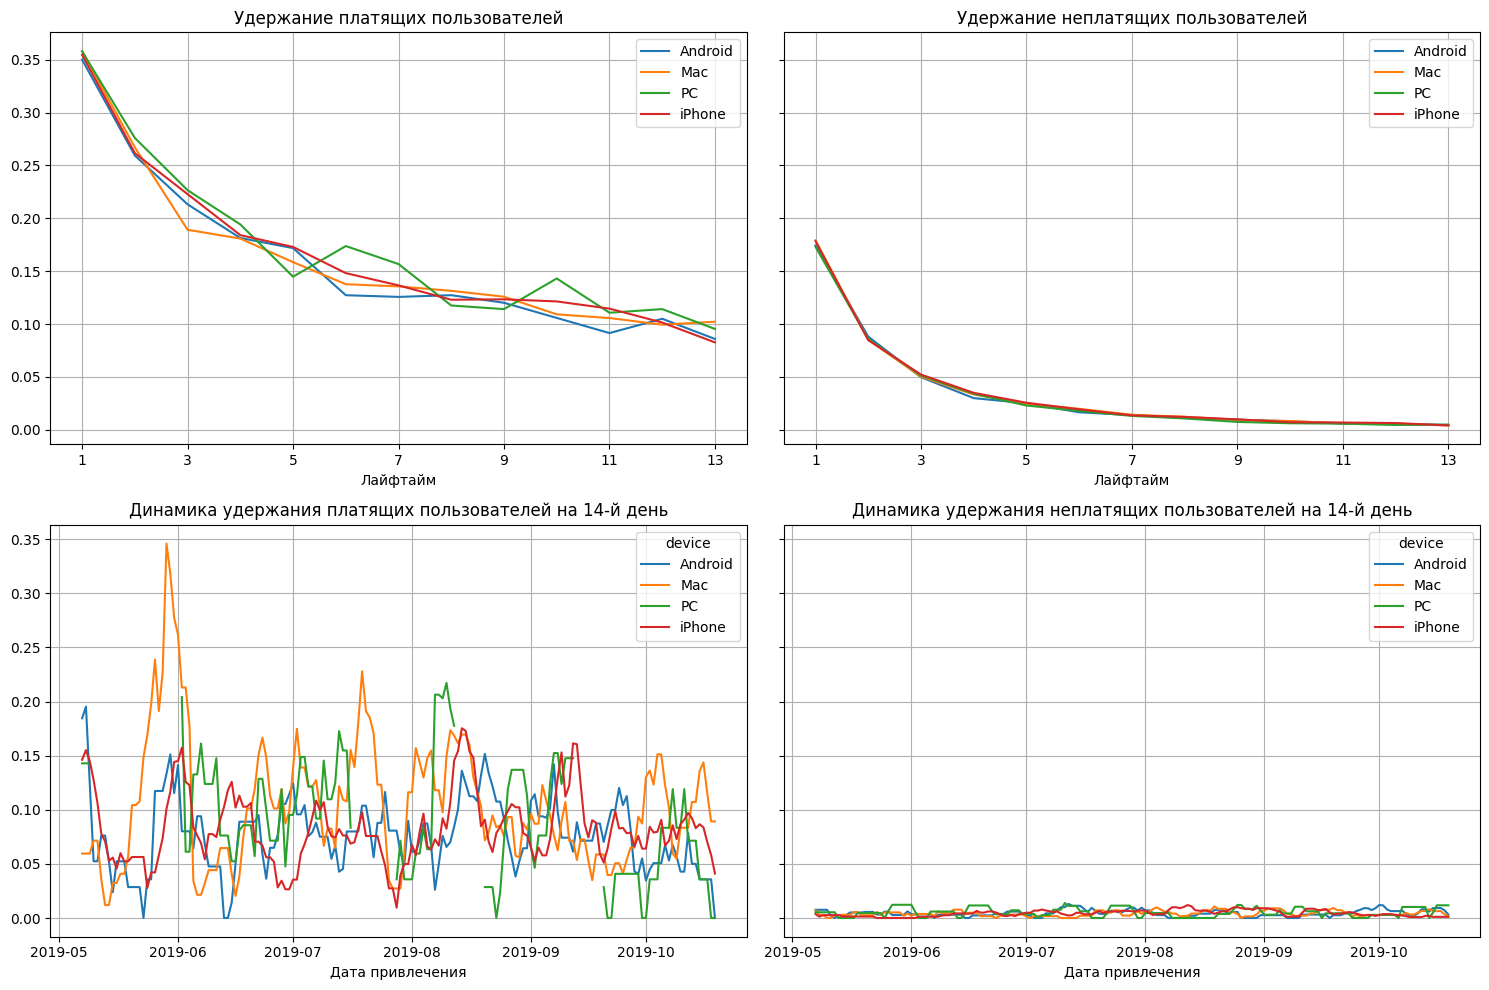

In [69]:
retention_raw, retention_grouped, retention_history = get_retention(
    us_profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

По представленным графикам можно сделать вывод о том, что удержание пользователей не связано с используемым устройством. Все графики приблизительно равны и отлчаются друг от дуга несущественно.

### Анализ удержания по каналам

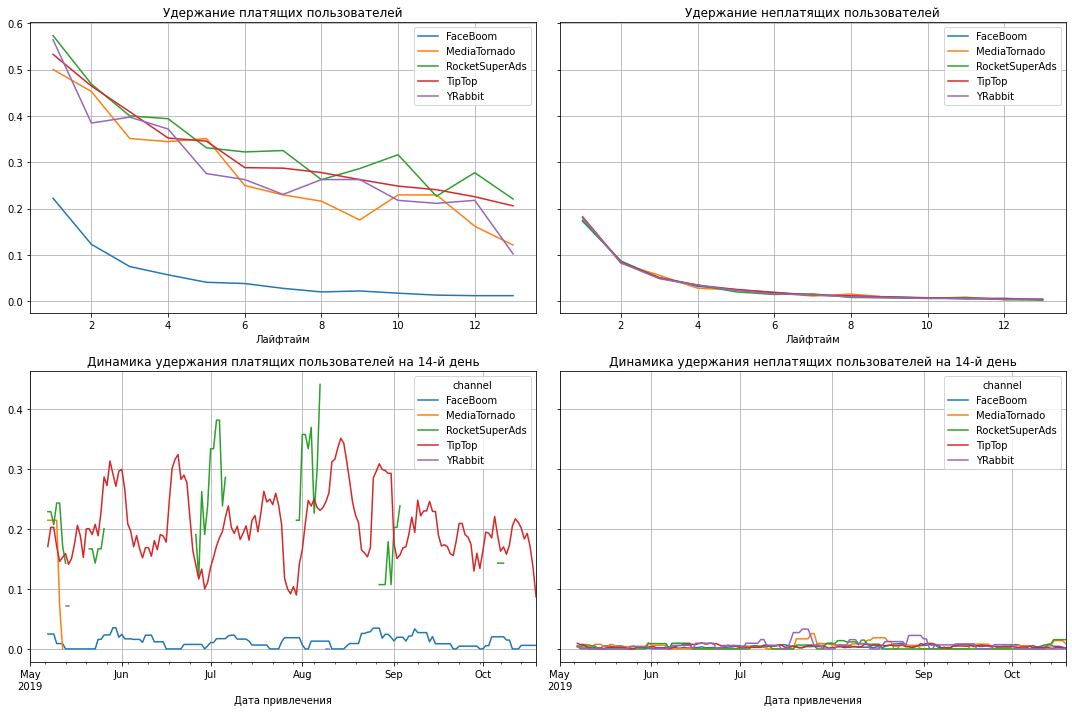

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    us_profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

На полученных графиках видно, что наименьшее удержание в среднем и в динамике у пользователей, привлеченных через канал FaceBoom, при этом у пользователей, привлеченных через этот канал, самая высокая конверсия.

**Выводы по разделу.**  

По результатам проведенного анализа можно сделать следующие выводы:  
- в целом выручка от рекламы не достигает уровня окупаемости, то есть затраты на рекламу превышают выгоду от маркетинговых кампаний;  
- негативное влияние на окупаемость оказывают рекламные кампании, проводимые в США и по каналам FaceBoom, TipTop и AdNonSense. Окупаемость не зависит от типа устройств;  
- низкая окупаемость может быть связана с ростом затрат на привлечение пользователей. Согласно разделу 5.2 данного исследования максимальные затраты на маркетинг осуществлены по каналам FaceBoom и TipTop. В то же время именно эти каналы показывают максимальный рост затрат на привлечение пользователей, при этом выручка по указанным каналам не достигает порога окупаемости. Кроме того, удержание пользователей, привлеченных через FaceBoom, стабильно минимальное в течение всего анализируемого периода.  


В качестве возможных рекомендаций отделу маркетинга можно выделить пересмотр политики по пользователям из США и отказ от привлечения пользователей через каналы FaceBoom и TipTop, как наименее рентабельных.

## Выводы  

В рамках данного проекта мы провели исследование окупаемости маркетинговых кампаний приложения Procrastination Pro+.  
Целью данного исследования является определение причин убытков и подготовка рекомендации по повышению эффективности рекламы.  

В качестве исходной информации предоставлены три датасета с информацией о пользователях, привлеченных с 1 мая по 27 октября 2019 года:  
- лог сервера с данными об их посещениях (*visits_info_short.csv*);  
- выгрузка их покупок за этот период (*orders_info_short.csv*);  
- рекламные расходы (*costs_info_short.csv*).  

Исследование состояло из шести этапов:  
1) Загрузка и изучение предоставленных данных, в ходе которого мы познакомились с предоставленными данными, изучили информацию о них и выявили недостатки;  
2) Предобработка данных, в результате которой мы провели корректировку наименований столбцов, изменили типы данных в столбцах, где это было необходимо, а также провели проверку данных на наличие дубликатов;  
3) Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии, а также функции для визуализации этих метрик;  
4) Исследовательский анализ данных:   
   - Получение профилей пользователей, в которых отражены дата первого подключения пользователя, источник подключения, вид устройства, страна, дата и месяц подключения, вхождение в состав платящих пользователей, а также стоимость привлечения. Также мы определили, что минимальной датой привлечения пользователей является 1 мая 2019 года, а максимальной с учетом горизонта анализа - 19 октября 2019 года;    
   - Анализ по странам, в ходе которого было выявлено, что пользователи приходят в приложение из США, Германии, Великобритании и Франции. Наибольшая доля покупателей приходится на США (более 6%). Эта же страна является лидером по посещениям приложения;    
   - Анализ по устройствам, в результате которого определено, что пользователи приложения пользуются устройствами Mac, iPhone, Android, PC. Наибольшая доля платящих пользователей среди использующих Mac. На втором месте владельцы iPhone;    
   - Анализ по источникам привлечения. По результатам анализа выявлено, что пользователи приходят в приложение через следующие каналы: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds, WahooNetBanner, YRabbit, MediaTornado, LeapBob, OppleCreativeMedia. Почти половина пользователей попадают в приложение самостоятельно, однако доля платящих пользователей среди "органических" пользователей минимальна. Больше всего платящих пользователей среди пришедших через FaceBoom (более 12%).  
   
5) Маркетинговое исследование:  
   - Определены общие расходы на маркетинг в течение анализируемого периода, которые составили 105 497.3 у.е.;  
   - В ходе анализа затрат на маркетинг по источникам определено, что наибольшая доля маркетинговых расходов приходится на канал TipTop (54751.30 у.е.). На втором месте FaceBoom (32445.60 у.е.). 
   - Выявлен существеный рост расходов на маркетинг по каналам TipTop и FaceBoom. По остальным каналам наблюдаются стабильно низкие затраты.  
   - Определена максимальная средняя удельная стоимость привлечения пользователей у источника TipTop - 2,80 у.е./чел. Минимальное значение у LeapBob - 0.21 у.е./чел. 
  
   
6) Оценка окупаемости рекламы:  
   - Анализ окупаемости рекламы:  
      - реклама не окупается. Уровень ROI к 14 дню составляет чуть более 80%;  
      - наблюдается снижение окупаемости в течение года: до июня ROI превышает уровень окупаемости, а после середины июня не достигает его и стабильно снижается;  
      - наблюдается рост САС. Возможно, отсутствие окупаемости может быть связано с ростом затрат на рекламу;  
      - LTV стабилен, как и его динамика. Значит, дело не в ухудшении качества пользователей.
   - Анализ окупаемости с разбивкой по устройствам:  
     - окупаемость рекламы слегка превышает уровень окупаемости только у пользователей PC. ROI пользователей Android на 14 день достигает 0.9, а окупаемость пользователей Mac и iPhone находится на уровне 0.7;  
     - динамика ROI имеет тенденцию к снижению у всех категорий пользователей;  
     - также наблюдается рост стоимости привлечения пользователей по всем типам устройств. Наибольший рост стоимости наблюдается у пользователей Mac и iPhone;
     - LTV стабилен для всех устройств.
   - Анализ окупаемости с разбивкой по странам:  
     - LTV пользователей из США значительно превышает и выдалется на фоне остальных регионов. На графике динамики также видно, что LTV для США в среднем стабильно выше, за исключением нескольких аномально высоких значений для Великобритании и Германии;  
     - в то же время окупаемость рекламы превышает уровень окупаемости для всех регионов, кроме США. Так, ROI для Франции и Германии находится в районе 1.5, для Великобритании - 1.6. Окупаемость пользователей из США не достигает уровня окупаемости и составляет около 0.7. Динамика окупаемости для США также стабильно ниже порога окупаемости и имеет енденцию к снижению в течение года, а отличие от остальных стран;  
     - стоимость привлечения пользователей из США показывает стабильный и устойчивый рост в течение периода исследования, в отличие от стоимости привлечения покупателей из других стран.  
   - Анализ окупаемости с разбивкой по каналам привлечения:  
     - LTV пользователей, привлеченных через lambdaMediaAds и TipTop максимальны, это же видно и на графике динамики LTV;  
     - стоимость привлечения пользователей через TipTop существенно выросла в течение анализируемого периода. Стоимость привлечения по другим каналам достаточно стабильна;  
     - доходы с пользователей, привлекаемых по каналам AdNonSense, FaceBoom и TipTop не окупаются. Это видно и на графике динамики ROI: доходы по этим каналам не превышают уровень окупаемости стабильно в течение всего срока анализа. При этом окупаемость пользователей, привлеченных через TipTop минимальна.  
     В связи с тем, что доходность маркетинговых кампаний в США не достигает уровня окупаемости стабильно ниже уровня окупаемости, был проведен дополнительный анализ пользователей из США, а именно: был проведен анализ конверсии и удержания по устройствам и каналам привлечения.  
   - Анализ конверсии по устройствам: наиболее хорошо конвертируются пользователи Android. Пользователи Mac, iPhone и PC находятся приблизительно на одном уровне. За весь анализируемый период наблюдается рост конверсии по всем категориям устройств.  
   - Анализ конверсии по каналам привлечения: максимальная конверсия в среднем и в течение всего анализируемого периода у пользователей, привлеченных через FaceBoom. На втором месте TipTop. Минимальная конверсия у MediaTornado и YRabbit. Не смотря на некоторую сезонность, конверсия по всем каналам привлечения остается стабильной за весь анализируемй период. Таким образом, можно сделать промежуточный вывод о том, что проблема окупаемости не связана с конверсией. Следующим этапом проанализируем удержание пользователей.  
   - Анализ удержания по устройствам: выявлено, что удержание пользователей не связано с используемым устройством. Все графики приблизительно равны и отличаются друг от дуга несущественно.   
   - Анализ удержания по каналам привлечения: наименьшее удержание в среднем и в динамике у пользователей, привлеченных через канал FaceBoom, при этом у пользователей, привлеченных через этот канал, самая высокая конверсия.  
   
   
В целом выручка от рекламы не достигает уровня окупаемости, то есть затраты на рекламу превышают выгоду от маркетинговых кампаний. На графиках видно, что темп снижения выручки сопоставим с темпом роста затрат на привлечение пользователей в течение анализируемого периода.  
Негативное влияние на окупаемость оказывают рекламные кампании, проводимые в США и по каналам FaceBoom, TipTop и AdNonSense.  

Низкая окупаемость может быть связана с ростом затрат на привлечение пользователей. Согласно разделу 5.2 данного исследования максимальные затраты на маркетинг осуществлены по каналам FaceBoom и TipTop. В то же время именно эти каналы показывают максимальный рост удельной стоимости привлечения пользователей, при этом выручка по указанным каналам не достигает порога окупаемости. Кроме того, удержание пользователей, привлеченных через FaceBoom, стабильно минимальное в течение всего анализируемого периода.  

В качестве возможных рекомендаций отделу маркетинга можно выделить пересмотр политики по пользователям из США и отказ от привлечения пользователей через каналы FaceBoom и TipTop, как наиболее затратных и наименее рентабельных. Возможно, следует обратить внимание на канал RocketSuperAds: пользователи, привлеченные по этому каналу, показывают довольно высокий уровень удержания и среднюю конверсию. Кроме того, выручка от таких пользователей стабильно превышает порог окупаемости, а удельная стоимость привлечения держится на одном уровне в течение всего анализируемого периода.  